# ML Pipeline Preparation

In [153]:
import pandas as pd
import numpy as np
import re

import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag

from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import sqlite3
import sqlalchemy as sqldb

import pickle
import json

In [103]:
# loading data from database
connection = sqlite3.connect('../data/02_trusted/worldbank.db')

df = pd.read_sql("SELECT * FROM messages_dataset", con=connection, index_col='index')
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
index,,,,,,,,,,,,,,,,,,,,,
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
# spliting the data between X and y
X = df['message']
y = df.drop(['id','message','original','genre'], axis=1)
print(y.shape)

def load_data():
    connection = sqlite3.connect('../data/02_trusted/worldbank.db')
    df = pd.read_sql("SELECT * FROM messages_dataset", con=connection, index_col='index')
    X = df['message']
    y = df.drop(['id','message','original','genre'], axis=1)
    return X, y


(26216, 36)


In [105]:
# writing a tokenization function to process your text data
def tokenize(text):
    # cleaning and normalizing
    text = re.sub("\W",' ',text.lower())
    # tokenizing
    words = word_tokenize(text)
    # removing stop words
    words = np.array(words)
    words = words[~np.isin(words,stopwords.words('english'))]
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return words

In [106]:
tokenize(X.iloc[900])

['always',
 'commune',
 'gressier',
 'section',
 '24th',
 'note',
 'incomplete',
 'ask',
 'detail',
 'help']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [129]:
def build_pipelines(classifiers):
    pipelines = {}
    for algorithm,classifier in classifiers.items():
        pipeline = Pipeline([
            ('vect',CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer(smooth_idf=False)),
            ('clf',MultiOutputClassifier(classifier))
        ])
        pipelines[algorithm] = pipeline

    return pipelines

In [122]:
def build_pipeline():
    pipeline = Pipeline([
        ('vect',CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer(smooth_idf=False)),
        ('clf',MultiOutputClassifier(XGBClassifier()))
    ])

    return pipeline

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [123]:
X, y = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y)

pipeline  = build_pipeline()

pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [124]:
columns = y_test.columns
for i, col in enumerate(columns):
    print(col)
    print(classification_report(y_test[col], y_pred[:,i]))
    print('___________________________________')


related
              precision    recall  f1-score   support

           0       0.71      0.37      0.49      1480
           1       0.83      0.95      0.89      5026
           2       0.62      0.17      0.26        48

    accuracy                           0.82      6554
   macro avg       0.72      0.50      0.55      6554
weighted avg       0.80      0.82      0.79      6554

___________________________________
request
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5405
           1       0.79      0.54      0.64      1149

    accuracy                           0.89      6554
   macro avg       0.85      0.75      0.79      6554
weighted avg       0.89      0.89      0.89      6554

___________________________________
offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6514
           1       0.00      0.00      0.00        40

    accuracy                      

### 6. Improve your model
Use grid search to find better parameters. 

In [121]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x000001E3BF760318>)),
  ('tfidf', TfidfTransformer(smooth_idf=False)),
  ('clf', MultiOutputClassifier(estimator=LGBMClassifier()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x000001E3BF760318>),
 'tfidf': TfidfTransformer(smooth_idf=False),
 'clf': MultiOutputClassifier(estimator=LGBMClassifier()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': False,
 'tfidf__subli

In [130]:
def build_models(classifiers,parameters_dict):
    pipelines = build_pipelines(classifiers)

    cvs = {}
    
    for algorithm,parameters in parameters_dict.items():
        # create grid search object
        cv = GridSearchCV(pipelines[algorithm], param_grid=parameters)
        cvs[algorithm] = cv
    
    return cvs

In [111]:
def build_model():
    pipeline = build_pipeline()

    # specify parameters for grid search
    parameters = {
        'clf__estimator__n_estimators': [50, 100, 200],
        'clf__estimator__min_samples_split': [2, 3, 4]
    }

    # create grid search object
    cv = GridSearchCV(pipeline, param_grid=parameters)
    
    return cv

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [112]:
def display_results(cv,y_test,y_pred):
    columns = y_test.columns
    for i, col in enumerate(columns):
        print(col)
        print(classification_report(y_test[col], y_pred[:,i]))
        print('___________________________________')
        
    print("\nBest Parameters:", cv.best_params_)

    

def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    model = build_model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    display_results(model, y_test, y_pred)

    return model


model  = main()

related
              precision    recall  f1-score   support

           0       0.71      0.41      0.52      1463
           1       0.84      0.95      0.89      5046
           2       0.77      0.22      0.34        45

    accuracy                           0.83      6554
   macro avg       0.78      0.53      0.59      6554
weighted avg       0.81      0.83      0.81      6554

___________________________________
request
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5414
           1       0.86      0.47      0.61      1140

    accuracy                           0.89      6554
   macro avg       0.88      0.73      0.77      6554
weighted avg       0.89      0.89      0.88      6554

___________________________________
offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6522
           1       0.00      0.00      0.00        32

    accuracy                      

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6421
           1       0.25      0.01      0.01       133

    accuracy                           0.98      6554
   macro avg       0.61      0.50      0.50      6554
weighted avg       0.97      0.98      0.97      6554

___________________________________
military
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      6341
           1       0.65      0.05      0.10       213

    accuracy                           0.97      6554
   macro avg       0.81      0.53      0.54      6554
weighted avg       0.96      0.97      0.95      6554

___________________________________
child_alone
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6554

    accuracy                           1.00      6554
   macro avg       1.00      1.00      1.00      6554
weighted avg       1.00      1.00  

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.95      1.00      0.98      6213
           1       0.81      0.11      0.20       341

    accuracy                           0.95      6554
   macro avg       0.88      0.56      0.59      6554
weighted avg       0.95      0.95      0.94      6554

___________________________________
electricity
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6416
           1       0.57      0.03      0.06       138

    accuracy                           0.98      6554
   macro avg       0.78      0.51      0.52      6554
weighted avg       0.97      0.98      0.97      6554

___________________________________
tools
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6514
           1       0.00      0.00      0.00        40

    accuracy                           0.99      6554
   macro avg       0.50      0.50     

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4668
           1       0.85      0.71      0.77      1886

    accuracy                           0.88      6554
   macro avg       0.87      0.83      0.85      6554
weighted avg       0.88      0.88      0.88      6554

___________________________________
floods
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5988
           1       0.90      0.47      0.62       566

    accuracy                           0.95      6554
   macro avg       0.93      0.73      0.80      6554
weighted avg       0.95      0.95      0.94      6554

___________________________________
storm
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      5941
           1       0.76      0.54      0.63       613

    accuracy                           0.94      6554
   macro avg       0.86      0.76      0.80

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [156]:
def display_and_store_results(cv,y_test,y_pred,algorithm):
    
    columns = y_test.columns
    classification_reports = []
    for i, col in enumerate(columns):
        print(col)
        classif_report = classification_report(y_test[col], y_pred[:,i])
        print(classif_report)
        classification_reports.append(classif_report)
        print('___________________________________')
        
    print("\nBest Parameters:", cv.best_params_)
    print('##################################')

    performance = {
        'algorithm':algorithm,
        'best_params':cv.best_params_,
        'class':classification_reports
    }

    patch = '../data/03_models/'
    filename = patch + algorithm

    json.dump(performance, open(filename+'_results.json', 'w'))   
    pickle.dump(model.best_estimator_, open(filename+'.pkl', 'wb'))

    

def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

    parameters = {
        'LGBMClassifier':{'clf__estimator__subsample': [0.6, 0.8, 1.0],
                          'clf__estimator__n_estimators': [50, 100, 200]},
        'XGBClassifier':{'clf__estimator__subsample': [0.6, 0.8, 1.0],
                         'clf__estimator__n_estimators': [50, 100, 200]}
    }

    classifiers = {
                   'LGBMClassifier':LGBMClassifier(),
                   'XGBClassifier':XGBClassifier()
    }

    models = build_models(classifiers,parameters)

    for algorithm, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        display_and_store_results(model, y_test, y_pred, algorithm)

    return models


models  = main()

In [157]:
for algorithm, model in models.items():
    y_pred = model.predict(X_test)
    display_and_store_results(model, y_test, y_pred, algorithm)

related
              precision    recall  f1-score   support

           0       0.76      0.53      0.63      1480
           1       0.87      0.95      0.91      5026
           2       0.79      0.40      0.53        48

    accuracy                           0.85      6554
   macro avg       0.81      0.63      0.69      6554
weighted avg       0.84      0.85      0.84      6554

___________________________________
request
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5405
           1       0.86      0.63      0.72      1149

    accuracy                           0.92      6554
   macro avg       0.89      0.80      0.84      6554
weighted avg       0.91      0.92      0.91      6554

___________________________________
offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6514
           1       1.00      0.75      0.86        40

    accuracy                      

In [139]:
d={}
for algorithm, model in models.items():

    y_pred = model.predict(X_test)
    performance = {}
    for i, col in enumerate(columns):
        print(col)
        performance[col] = f1_score(y_test[col], y_pred[:,i],average=None)
        print('___________________________________')
    d[algorithm] = performance

related
___________________________________
request
___________________________________
offer
___________________________________
aid_related
___________________________________
medical_help
___________________________________
medical_products
___________________________________
search_and_rescue
___________________________________
security
___________________________________
military
___________________________________
child_alone
___________________________________
water
___________________________________
food
___________________________________
shelter
___________________________________
clothing
___________________________________
money
___________________________________
missing_people
___________________________________
refugees
___________________________________
death
___________________________________
other_aid
___________________________________
infrastructure_related
___________________________________
transport
___________________________________
buildings
_______________

In [148]:
df_performance = pd.DataFrame(d)
df_performance.head()

,LGBMClassifier,XGBClassifier
related,"[0.6259968102073366, 0.9084346504559271, 0.527...","[0.710801393728223, 0.926936704012257, 0.65853..."
request,"[0.9506339357971406, 0.7237040764972321]","[0.9573741007194244, 0.761569416498994]"
offer,"[0.9992330111980365, 0.8571428571428571]","[0.9986968187044845, 0.7301587301587301]"
aid_related,"[0.8512533401196081, 0.7772909125547722]","[0.875062719518314, 0.8060747663551403]"
medical_help,"[0.971554683668465, 0.6018306636155607]","[0.9740440514206175, 0.6458100558659218]"


In [149]:
df_performance['LGBMClassifier'] = df_performance['LGBMClassifier'].apply(lambda x : x[-1])
df_performance['XGBClassifier']  = df_performance['XGBClassifier'].apply(lambda x : x[-1])
df_performance['Comparisson'] = df_performance['LGBMClassifier'] - df_performance['XGBClassifier'] 

In [158]:
df_performance

,LGBMClassifier,XGBClassifier,Comparisson
related,0.527778,0.658537,-0.130759
request,0.723704,0.761569,-0.037865
offer,0.857143,0.730159,0.126984
aid_related,0.777291,0.806075,-0.028784
medical_help,0.601831,0.645810,-0.043979
medical_products,0.657143,0.695353,-0.038210
search_and_rescue,0.522727,0.604982,-0.082255
security,0.455090,0.409639,0.045451
military,0.791878,0.784615,0.007263
child_alone,1.000000,1.000000,0.000000


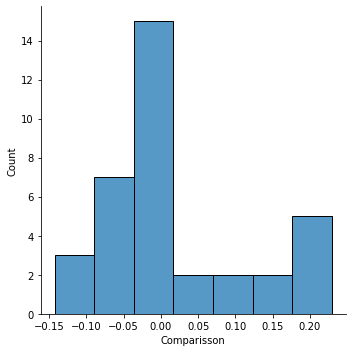

In [154]:
sns.displot(df_performance['Comparisson'])

Light GBM has shown a better overall performance than XGBoost

### 9. Export your model as a pickle file

In [155]:
filename = 'random_forest.sav'
patch = '../data/03_models/'
pickle.dump(model.best_estimator_, open(patch+filename, 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.